# **Graduate School Admissions Predictions**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Load Data**

In [346]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
df.columns
# Remove unnecessary spaces in column names
df.rename(columns={'Chance of Admit ':'Chance of Admit', 'LOR ':'LOR'}, inplace=True)
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


**Clean Data**

In [347]:
df.drop(columns=['Serial No.'], inplace=True)
print(df.isna().sum())
df.head()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


**Analysis and Visualization**

In [348]:
df["Chance of Admit"].max()

0.97

Guaranteed admissions (100% chance of admit) are not present in this dataset.

**Test Scores: GRE & TOEFL**

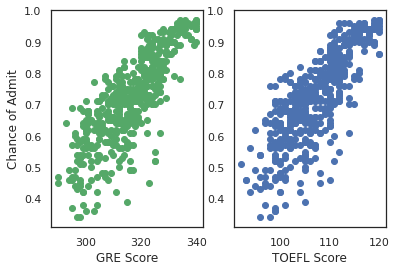

In [349]:
# GRE 
plt.subplot(1,2,1)
plt.scatter(df['GRE Score'], df['Chance of Admit'], color='g')
plt.xlabel('GRE Score')
plt.ylabel('Chance of Admit')
# TOEFL 
plt.subplot(1,2,2)
plt.scatter(df['TOEFL Score'], df['Chance of Admit'], color='b')
plt.xlabel('TOEFL Score')
plt.show()

**University Rating**

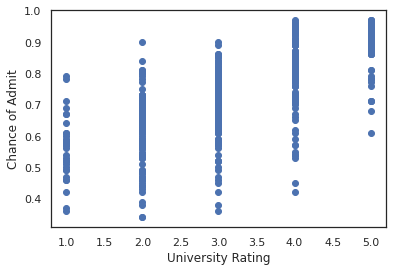

In [350]:
plt.scatter(df['University Rating'], df['Chance of Admit'], color='b')
plt.xlabel('University Rating')
plt.ylabel('Chance of Admit')
plt.show()

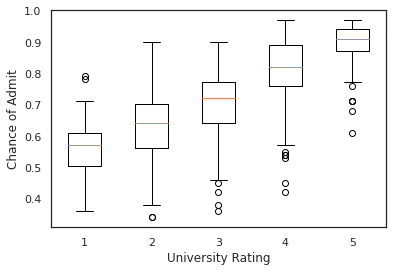

,Min,Max,Range,Average
University Rating,,,,
1,0.36,0.79,0.43,0.562059
2,0.34,0.90,0.56,0.626111
3,0.36,0.90,0.54,0.702901
4,0.42,0.97,0.55,0.801619
5,0.61,0.97,0.36,0.888082


In [351]:
x = df.groupby(df['University Rating'])['Chance of Admit'].apply(list)
plt.boxplot(x)
plt.xlabel('University Rating')
plt.ylabel('Chance of Admit')
plt.show()

mx = df.groupby(df['University Rating'])['Chance of Admit'].max().sort_values(ascending=False)
mn = df.groupby(df['University Rating'])['Chance of Admit'].min().sort_values(ascending=False)
avg = df.groupby(df['University Rating'])['Chance of Admit'].mean().sort_values(ascending=False)
rng = mx - mn
pd.DataFrame({'Min':mn, 'Max':mx, 'Range':rng, 'Average':avg})

**Supplemental Forms: LOR & SOP**

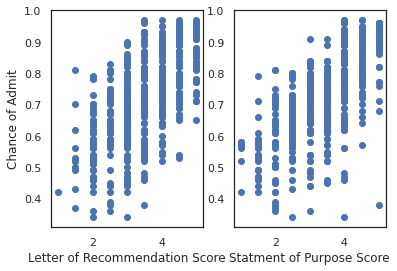

,LOR,SOP
1.0,0.420000,0.538333
1.5,0.550000,0.546400
2.0,0.568261,0.589535
2.5,0.640600,0.645312
3.0,0.668485,0.678500
3.5,0.723023,0.712045
4.0,0.764149,0.782809
4.5,0.831905,0.850000
5.0,0.872600,0.885000


In [352]:
plt.subplot(1,2,1)
plt.scatter(df.LOR, df['Chance of Admit'])
plt.xlabel('Letter of Recommendation Score')
plt.ylabel('Chance of Admit')
plt.subplot(1,2,2)
plt.scatter(df.SOP, df['Chance of Admit'])
plt.xlabel('Statment of Purpose Score')
plt.show()

pd.DataFrame({'LOR': df.groupby(df.LOR)['Chance of Admit'].mean(), 'SOP':df.groupby(df.SOP)['Chance of Admit'].mean()})

In [353]:
df[((df.SOP == 4) | (df.SOP == 5)) & (df['Chance of Admit'] <= .4)]

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
91,299,97,3,5.0,3.5,7.66,0,0.38
92,298,98,2,4.0,3.0,8.03,0,0.34


**Cumulative GPA**

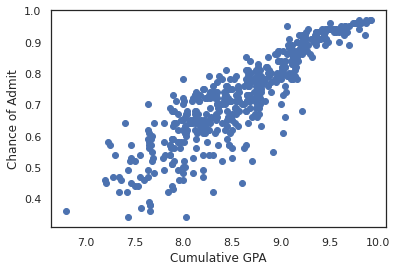

In [354]:
plt.scatter(df.CGPA, df['Chance of Admit'])
plt.xlabel('Cumulative GPA')
plt.ylabel('Chance of Admit')
plt.show()

**GPA vs Research**

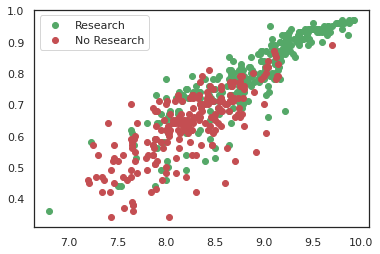

Highest Chance of Admission without Research: 89.0%
Average Chance of Admit
Research: 79.0%
No Research: 63.49%


In [355]:
r = df[df.Research == 1]
nr = df[df.Research == 0]
plt.scatter(r.CGPA, r['Chance of Admit'], color='g', label='Research')
plt.scatter(nr.CGPA, nr['Chance of Admit'], color='r', label='No Research')
plt.legend()
plt.show()
print(f"Highest Chance of Admission without Research: {nr['Chance of Admit'].max() * 100}%")
print('Average Chance of Admit')
print(f"Research: {round(r['Chance of Admit'].mean() * 100, 2)}%")
print(f"No Research: {round(nr['Chance of Admit'].mean() * 100, 2)}%")

### **Regression Model**

**Split Dataset**

In [356]:
train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(df.shape, train_data.shape, test_data.shape)

(500, 8) (400, 8) (100, 8)


**Inspect Data**

In [357]:
import seaborn as sns
sns.set()
sns.pairplot(train_data[["GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR", "CGPA", "Research", "Chance of Admit"]], diag_kind="kde")

'import seaborn as sns\nsns.set()\nsns.pairplot(train_data[["GRE Score", "TOEFL Score", "University Rating", "SOP", "LOR", "CGPA", "Research", "Chance of Admit"]], diag_kind="kde")'

In [358]:
train_stats = train_data.drop(columns=['Chance of Admit']).describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
GRE Score,400.0,316.217500,11.225651,290.0,308.00,316.00,324.25,340.00
TOEFL Score,400.0,107.082500,6.020907,92.0,102.00,107.00,112.00,120.00
University Rating,400.0,3.065000,1.126476,1.0,2.00,3.00,4.00,5.00
SOP,400.0,3.346250,0.983312,1.0,2.50,3.50,4.00,5.00
LOR,400.0,3.460000,0.902322,1.0,3.00,3.50,4.00,5.00
CGPA,400.0,8.562925,0.591376,6.8,8.12,8.54,9.02,9.92
Research,400.0,0.562500,0.496700,0.0,0.00,1.00,1.00,1.00


**Create Heatmap**

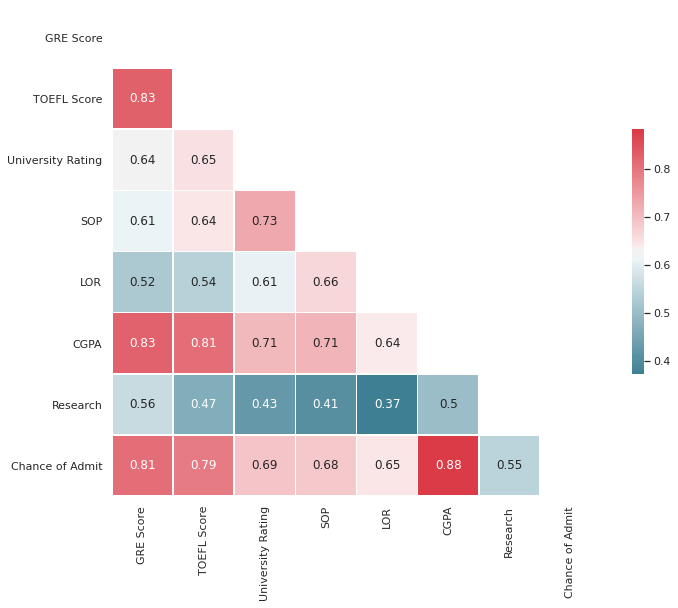

In [359]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

**Select Labels**

In [0]:
train_labels = train_data.pop('Chance of Admit')
test_labels = test_data.pop('Chance of Admit')

**Normalize Data**

In [0]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
    
normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

**Build Model**

In [0]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

def build_model():
    model = keras.Sequential([
                              layers.Dense(8, activation='relu', input_shape=[len(train_data.keys())]),
                              layers.Dense(16, activation='relu'),
                              layers.Dense(1)
                              ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    
    return model

model = build_model()

**Model Inspection**

In [363]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 8)                 64        
_________________________________________________________________
dense_40 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 17        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [364]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-1.0158746 ],
       [ 0.05044607],
       [-0.24585041],
       [ 0.07782655],
       [ 0.02731206],
       [ 0.67250764],
       [ 0.06486315],
       [ 0.2821083 ],
       [-0.09774423],
       [-0.4202742 ]], dtype=float32)

**Train Model**

In [365]:
history = model.fit(
    normed_train_data, train_labels,
    epochs=60, validation_split = 0.2,
    verbose=1
)

Epoch 1/60
10/10 [==============================] - 0s 12ms/step - loss: 0.4880 - mae: 0.6286 - mse: 0.4880 - val_loss: 0.4001 - val_mae: 0.5558 - val_mse: 0.4001
Epoch 2/60
10/10 [==============================] - 0s 4ms/step - loss: 0.3391 - mae: 0.5163 - mse: 0.3391 - val_loss: 0.3063 - val_mae: 0.4811 - val_mse: 0.3063
Epoch 3/60
10/10 [==============================] - 0s 4ms/step - loss: 0.2596 - mae: 0.4525 - mse: 0.2596 - val_loss: 0.2383 - val_mae: 0.4239 - val_mse: 0.2383
Epoch 4/60
10/10 [==============================] - 0s 4ms/step - loss: 0.1994 - mae: 0.3957 - mse: 0.1994 - val_loss: 0.1831 - val_mae: 0.3704 - val_mse: 0.1831
Epoch 5/60
10/10 [==============================] - 0s 4ms/step - loss: 0.1496 - mae: 0.3396 - mse: 0.1496 - val_loss: 0.1390 - val_mae: 0.3185 - val_mse: 0.1390
Epoch 6/60
10/10 [==============================] - 0s 4ms/step - loss: 0.1120 - mae: 0.2882 - mse: 0.1120 - val_loss: 0.1071 - val_mae: 0.2759 - val_mse: 0.1071
Epoch 7/60
10/10 [=========

In [366]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
55,0.003649,0.044885,0.003649,0.005736,0.058718,0.005736,55
56,0.003604,0.044374,0.003604,0.005749,0.060251,0.005749,56
57,0.003631,0.045216,0.003631,0.005584,0.059175,0.005584,57
58,0.003460,0.043517,0.003460,0.005891,0.061891,0.005891,58
59,0.003532,0.044435,0.003532,0.005503,0.057833,0.005503,59


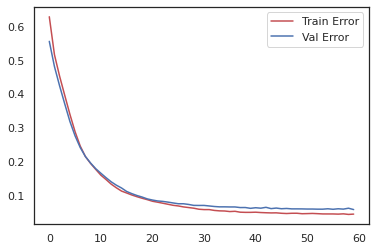

In [367]:
plt.plot(hist.epoch, hist.mae, color='r', label='Train Error')
plt.plot(hist.epoch, hist.val_mae, color='b', label='Val Error')
plt.legend()
plt.show()

**Predictions**

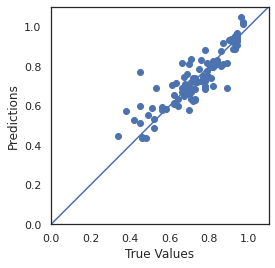

In [368]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1.1]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

In [369]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print(f"MAE: {round(mae*100,2)}%")

4/4 - 0s - loss: 0.0052 - mae: 0.0512 - mse: 0.0052
MAE: 5.12%


Text(0, 0.5, 'Frequency')

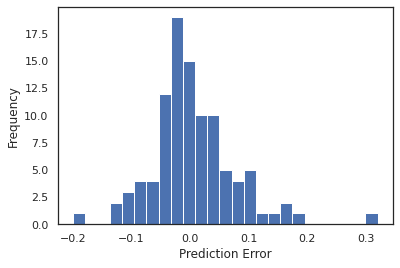

In [370]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")